## Importamos librerías

In [87]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from tqdm import tqdm

from deap import base  # Estructura que permite agrupar todos los componentes de nuestro algoritmo en una misma bolsa
from deap import creator  # Permite crear los componentes de nuestro algoritmo
from deap import tools  # Contiene funciones precargadas

from joblib import Parallel, delayed

In [88]:
import numpy as np
import os
import math
import time
import pandas as pd
import json
# NN
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
from torch import optim
from copy import deepcopy
from sklearn.model_selection import train_test_split
## Ploting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgba
## Progress bar
from tqdm.notebook import tqdm
# Path
import sys
sys.path.append('/home/sebacastillo/neuralnets/')
from src.utils import get_project_root
root = get_project_root()
## Check torch version
print(f'Using {torch.__version__}')

Using 2.0.0+cu117


# PARTICIONO LOS DATOS

# Leemos los datasets

In [89]:
def load_split_save_data(input_filename, output_name='EXP', split_type='train_test', train_ratio=0.75, validate_ratio=None, test_ratio=None):

    data = pd.read_csv(input_filename, header=None)

    # Check if 'exp' folder exists, create it if it doesn't
    if not os.path.exists('exp'):
        os.makedirs('exp')
    
    # Create a subfolder with the output_name
    output_path = os.path.join('exp', output_name)
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    if split_type == 'train_validate_test':
        if not validate_ratio or not test_ratio:
            raise ValueError("Please provide validate_ratio and test_ratio for 'train_validate_test' split type.")
        
        train_data, temp_data = train_test_split(data, train_size=train_ratio, random_state=42)
        validate_data, test_data = train_test_split(temp_data, train_size=validate_ratio / (validate_ratio + test_ratio), random_state=42)
        
        # Save the train, validate, and test data as CSV files in the output folder
        train_data.to_csv(os.path.join(output_path, f'{output_name}_train_data.csv'), index=False)
        validate_data.to_csv(os.path.join(output_path, f'{output_name}_validate_data.csv'), index=False)
        test_data.to_csv(os.path.join(output_path, f'{output_name}_test_data.csv'), index=False)


        return train_data, validate_data, test_data    

    elif split_type == 'train_test':
        train_data, test_data = train_test_split(data, train_size=train_ratio, random_state=42)
        
        # Save the train and test data as CSV files in the output folder
        train_data.to_csv(os.path.join(output_path, f'{output_name}_train_data.csv'), index=False)
        test_data.to_csv(os.path.join(output_path, f'{output_name}_test_data.csv'), index=False)


        return train_data, test_data
    
    else:
        raise ValueError("Invalid split_type. Use either 'train_validate_test' or 'train_test'.")


In [90]:
TRAIN, TEST = load_split_save_data('data/irisbin.csv' , output_name= "AlgoGen")

In [91]:
TRAIN.head()

,0,1,2,3,4,5,6
4,6.7,3.1,4.7,1.5,-1,1,-1
32,5.2,3.4,1.4,0.2,-1,-1,1
142,5.5,2.3,4.0,1.3,-1,1,-1
85,5.6,3.0,4.5,1.5,-1,1,-1
86,5.1,3.3,1.7,0.5,-1,-1,1


In [92]:

def transform_dataframe(df):
    # Ensure the dataframe has at least 3 columns
    if len(df.columns) < 3:
        raise ValueError("Dataframe must have at least 3 columns")

    # Create the new target variable, starting with all zeros
    df['Target'] = 0

    # Loop over the last three columns in reverse order
    for i, column in enumerate(df.columns[-3:][::-1], start=0):
        df.loc[df[column] == 1, 'Target'] = i

    # Drop the last three columns
    df = df.drop(df.columns[-4:-1], axis=1)
    return df

In [93]:
TRAIN = transform_dataframe(TRAIN)
TRAIN.head()
TEST  = transform_dataframe(TEST)
TEST.head()

,0,1,2,3,Target
73,5.4,3.0,4.5,1.5,2
18,4.3,3.0,1.1,0.1,1
118,4.7,3.2,1.3,0.2,1
78,5.2,3.4,1.4,0.2,1
76,5.4,3.9,1.7,0.4,1


In [94]:
TRAIN.Target.value_counts()

Target
1    46
0    35
2    31
Name: count, dtype: int64

# Normalizamos los datos

In [95]:
scaler = StandardScaler()
TRAIN = TRAIN.to_numpy()
TEST = TEST.to_numpy()

In [96]:
X_TRAIN = TRAIN[:,:-1]
#y_train = (TRAIN[:,-1] + 1) /2
y_train = TRAIN[:,-1]
#y_train = np.where(np.array(y_train) < 1, 0, 1).astype('int64')


X_TEST = TEST[:,:-1]
y_test = TEST[:,-1]
#y_test = np.where(np.array(y_test) == 2, 1, 0).astype('int64')

scaler.fit(X_TRAIN)

Xtrain = scaler.transform(X_TRAIN)
Xtest = scaler.transform(X_TEST)

In [97]:
Xtrain

array([[ 1.19948987, -0.0091386 ,  0.62171968,  0.52865488],
       [-0.72335648,  0.60497529, -1.15270189, -1.18947348],
       [-0.33878721, -1.64677564,  0.24532722,  0.26432744],
       [-0.21059746, -0.21384323,  0.51417898,  0.52865488],
       [-0.85154624,  0.40027066, -0.99139083, -0.79298232],
       [-0.46697697,  1.62849844, -0.99139083, -0.92514604],
       [ 2.48138743, -1.03266175,  1.80466738,  1.58596464],
       [-0.33878721, -1.64677564,  0.24532722,  0.26432744],
       [ 2.48138743, -1.03266175,  1.80466738,  1.58596464],
       [-0.21059746, -0.62325249,  0.72926038,  1.18947348],
       [-0.72335648,  0.60497529, -1.15270189, -1.18947348],
       [-0.21059746, -0.62325249,  0.72926038,  1.18947348],
       [ 2.48138743,  1.42379381,  1.69712668,  1.45380092],
       [ 0.8149206 , -0.62325249,  1.10565283,  1.45380092],
       [-0.59516673,  1.21908918, -1.09893154, -1.18947348],
       [-1.62068478, -1.64677564, -1.20647224, -1.05730976],
       [-0.85154624,  1.

In [98]:
print(y_train)
print(y_test)

[2. 1. 2. 2. 1. 1. 0. 2. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 2. 2. 1. 0. 1. 2.
 2. 1. 0. 2. 0. 0. 1. 1. 1. 2. 2. 1. 2. 1. 0. 2. 0. 2. 1. 2. 2. 0. 0. 2.
 0. 1. 2. 2. 2. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 1. 0. 0. 2. 2. 1. 2. 0. 2. 0. 1. 0. 2. 1. 0. 1. 1. 2. 1. 2. 1.
 1. 2. 2. 1. 0. 0. 1. 1. 2. 0. 1. 1. 0. 1. 1. 2.]
[2. 1. 1. 1. 1. 2. 0. 2. 1. 1. 1. 2. 2. 0. 0. 2. 2. 0. 1. 1. 0. 0. 2. 1.
 2. 2. 2. 1. 0. 0. 0. 1. 1. 2. 1. 1. 1. 0.]


## Funciones auxiliares

In [99]:
#=================================
def bin(p=0.9):
    '''
    Esta función genera un bit al azar.
    '''
    if random.random() < p:
        return 1
    else:
        return 0
#=================================


#=================================
def fitness(features, Xtrain, Xtest, y_train, y_test):
    '''
    Función de aptitud empleada por nuestro algoritmo.
    '''
    if not isinstance(features, np.ndarray):
        features = np.array(features)

    if not isinstance(features[0], bool):
        features = features.astype(bool)
    
    X_train = Xtrain[:,features]
    X_test = Xtest[:,features]
    
    mlp = MLPClassifier(hidden_layer_sizes=(5,3),
                        activation='tanh',
                        solver='adam',
                        alpha=0.0001,
                        learning_rate_init=0.001,
                        shuffle=True,
                        momentum=0.9,
                        validation_fraction=0.2,
                        n_iter_no_change=10,
                        random_state=42,
                        max_iter=3000).fit(X_train, y_train)

    yp = mlp.predict(X_test)

    acc = (y_test == yp).sum()/len(y_test)

    n_genes = 1 - (features.sum() / len(features))

    alpha = 0.5

    f = (alpha*acc + (1-alpha)*n_genes)
    
    return f, acc, n_genes
#=================================

    
#=================================
def mutation(ind, p):
    '''
    Esta función recorre el cromosoma y evalúa, para cada gen,
    si debe aplicar el operador de mutación.
    '''
    return [abs(i-1) if random.random() < p else i for i in ind]
#=================================

## Inicializamos parámetros del experimento

In [100]:
IND_SIZE = Xtrain.shape[1]  # Cantidad de genes en el cromosoma

POP_SIZE = 100  # Cantidad de individuos en la población
PM = 20./IND_SIZE  # Probabilidad de mutación [aproximadamente 1 gen por cromosoma]
#                   Experimento 4: con mayor probabilidad de mutación.
# PM = 20./IND_SIZE __experimento 2 mejoró el fitness y acc en la segunda generación pero luego se estancó
PX = 0.75  # Probabilidad de cruza
# PX = 0.85  # Probabilidad de cruza
GMAX = 20  # Cantidad máxima de generaciones que se ejecutará el algoritmo

In [101]:
print(IND_SIZE)
print(POP_SIZE)
print(PM)
print(PX)
print(GMAX)

4
100
5.0
0.75
20


## Creamos los componentes del algoritmo

**Documentación**: https://deap.readthedocs.io/en/master/api/creator.html

In [102]:
# CREAMOS LA FUNCION DE FITNESS
# Esta función tiene "1 OBJETIVO" a "MAXIMIZAR"
creator.create("Fitness",  # Nombre con el que se registra el componente
               base.Fitness,  # Clase de la que hereda
               weights=(1.0,)) 

#---------------------

# CREAMOS EL CONSTRUCTOR DE INDIVIDUOS
creator.create("Individual", # Nombre con el que se registra el componente
               list,  # Clase de la que hereda [Tipo de contenedor en este caso]
               fitness=creator.Fitness,
               acc=0,
               ngenes=0)  # Asignamos un método para evaluar el fitness del individuo

/home/sebacastillo/.neuralnets/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/sebacastillo/.neuralnets/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


## REGISTRAMOS COMPONENTES

In [103]:
toolbox = base.Toolbox()

#---------------------

# DEFINIMOS COMO CONSTRUIR UN GEN
# el algoritmo retenie la historia de fitnes de genes activos, contribuyendo !!!IMPORTANTE
# a la selección de las variables que contribuyen a mejorar el fitness
toolbox.register("attribute",  # Nombre con el que se registra el componente
                 bin,
                 p=1)
                        # Probabilidad de un "1":   exp1:0.1 =ELITE -- Fitness: 0.9513 -- NGENES: 694 -- Acc: 1.0
                        #                           exp2:0.2 =ELITE -- Fitness: 0.8885 -- NGENES: 1380 -- Acc: 0.9706
                        #                           exp3:0.05=ELITE -- Fitness: 0.9595 -- NGENES: 368 -- Acc: 0.9706
                     #                              exp5:0.05 + 20/caracteristicas mutacion: ELITE -- Fitness: 0.9757 -- NGENES: 346 -- Acc: 1.0
#---------------------

# DEFINIMOS COMO CONSTRUIR UN INDIVIDUO/CROMOSOMA
toolbox.register("individual",  # Nombre con el que se registra el componente
                 tools.initRepeat,  # Método usado para construir el cromosoma
                 creator.Individual,  # ...
                 toolbox.attribute,  # Función para construir cada gen
                 n=IND_SIZE)  # Número de genes del cromosoma/individuo (se repetirá la función construir gen)

#---------------------

# DEFINIMOS COMO CONSTRUIR LA POBLACION
toolbox.register("population",  # Nombre con el que se registra el componente
                 tools.initRepeat,  # Método usado para construir el cromosoma
                 list,
                 toolbox.individual)

#---------------------

# DEFINIMOS COMO REALIZAR LA CRUZA
toolbox.register("mate",  # Nombre con el que se registra el componente
                 tools.cxTwoPoint)  # 

#---------------------

# DEFINIMOS COMO REALIZAR LA MUTACION
toolbox.register("mutate",  # Nombre con el que se registra el componente
                 mutation,  # Método de mutación (definido como función más arriba)
                 p=PM)  # Parámetro que usa la mutación

#toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
#toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)

#---------------------

# DEFINIMOS COMO REALIZAR LA SELECCION DE INDIVIDUOS
toolbox.register("select",  # Nombre con el que se registra el componente
                 tools.selTournament,  # Método usado para selección [selRoulette | selTournament | ...]
                 tournsize=5)  # Parámetro que usa el torneo

## Definimos las estadísticas a calcular

In [104]:
# EXTRAEMOS EL FITNESS DE TODOS LOS INDIVIDUOS
stats_fit = tools.Statistics(key=lambda ind: ind.fitness.values[0])

# EXTRAEMOS EL ACC DE TODOS LOS INDIVIDUOS
stats_acc = tools.Statistics(key=lambda ind: ind.acc)

# EXTRAEMOS LA FRACCION DE GENES ACTIVOS DE TODOS LOS INDIVIDUOS
stats_frac_active_genes = tools.Statistics(key=lambda ind: ind.ngenes)

# EXTRAEMOS EL NUMERO DE GENES ACTIVOS DE TODOS LOS INDIVIDUOS
stats_active_genes = tools.Statistics(key=lambda ind: np.sum(ind))

mstats = tools.MultiStatistics(fitness=stats_fit,
                               acc=stats_acc,
                               frac_ngenes=stats_frac_active_genes,
                               ngenes=stats_active_genes)

mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

# INICIALIZAMOS UN LOGGER
logbook = tools.Logbook()

# Corremos el modelo con todas las features

In [105]:
f = fitness(np.ones(Xtrain.shape[1]), Xtrain, Xtest, y_train, y_test)

print(f'FITNESS: {f[0]:.4} -- NGENES: {int(Xtrain.shape[1])} -- Acc: {f[1]:.4}\n')

FITNESS: 0.5 -- NGENES: 4 -- Acc: 1.0



In [107]:
#================================================
# INICIALIZAMOS LA POBLACIÓN
#================================================
pop = toolbox.population(n=POP_SIZE)  # Inicializamos una población
#================================================


#================================================
# EVALUAMOS EL FITNESS DE LA POBLACION
#======================================
#fitnesses = list(map(toolbox.evaluate, pop))
fitnesses = Parallel(n_jobs=4, backend='multiprocessing')(delayed(fitness)(ind, Xtrain, Xtest, y_train, y_test) for ind in pop)
#================================================

#================================================
# ASIGNAMOS A CADA INDIVIDUO SU FITNESS
#========================================
for ind,fit in zip(pop, fitnesses):
    ind.fitness.values = fit  # Guardamos el fitness para cada individuo (en el individuo)
    ind.acc = fit[1]
    ind.ngenes = fit[2]
#================================================

records = mstats.compile(pop)
logbook.record(gen=0, **records)

AssertionError: Assigned values have not the same length than fitness weights

In [108]:
#################################################################################
# COMENZAMOS LA EVOLUCION
################################

for g in range(1,GMAX):#tqdm(range(GMAX)):

    #================================================
    # SELECCIONAMOS INDIVIDUO ELITE
    #================================
    idx_elite = np.argmax(fitnesses, axis=0)[0]  # Si maximizamos, hay que usar ".argmax()". El indiv. con mejor fitness
    elite = toolbox.clone(pop[idx_elite])
    del elite.fitness.values, elite.acc, elite.ngenes
    #================================================

    
    #================================================
    # HACEMOS UNA COPIA DE LA POBLACION ACTUAL
    #==========================================
    #offspring = toolbox.select(pop, POP_SIZE)  # Seleccionamos individuos para alcanzar
                                               # el tamaño de la población
    
    offspring = list(map(toolbox.clone, pop))  # Clonamos para tener nuevos individuos
                                                     # (contenedores independientes)
    #================================================


    #================================================
    # REALIZAMOS LA CRUZA DE LOS PADRES
    #====================================
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < PX:
            toolbox.mate(child1, child2)
            del child1.fitness.values, child1.acc, child1.ngenes
            del child2.fitness.values, child2.acc, child2.ngenes
    #================================================


    #================================================
    # MUTAMOS LOS HIJOS
    #=================================
    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values  #, mutant.acc, mutant.ngenes
    #================================================
    
    
    #================================================
    # EVALUAMOS EL FITNESS
    # Y SE LO ASIGNAMOS A CADA INDIVIDUO
    #======================================
    offspring[0] = elite
    
    fitnesses = Parallel(n_jobs=4, backend='multiprocessing')(delayed(fitness)(ind, Xtrain, Xtest, y_train, y_test) for ind in offspring)

    for ind, fit in zip(offspring, fitnesses):
        ind.fitness.values = (fit[0],)  # Guardamos el fitness para cada individuo (en el individuo)
        ind.acc = fit[1]
        ind.ngenes = fit[2]
    #================================================

    
    #================================================
    # CONSTRUIMOS LA NUEVA POBLACION
    #================================
    pop = toolbox.clone(offspring)
    #================================================

    
    #================================================
    # CALCULAMOS ESTADÏSTICAS
    #============================
    records = mstats.compile(pop)
    logbook.record(gen=g, **records)

    if (g%1 == 0):
        print('='*79)
        print(f'GENERATION: {g}')
        print(f'ELITE -- Fitness: {elite.fitness.values[0]:.4} -- NGENES: {np.sum(elite)} -- Acc: {elite.acc:.4}')
        print('FITNES: ', records['fitness'])
        print('ACC: ', records['acc'])
        print('GENES: ', records['ngenes'])
    #================================================

AttributeError: acc

## Graficamos la evolución del fitness

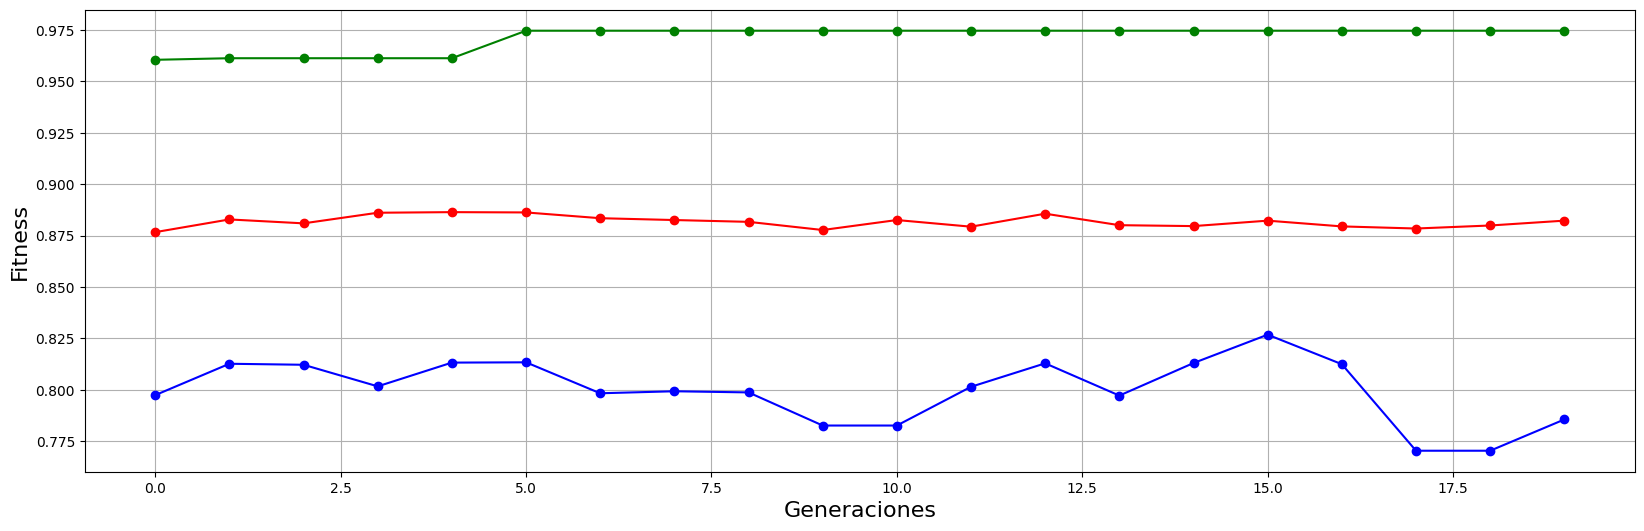

In [15]:
f_avg = logbook.chapters['fitness'].select('avg')  # Extraemos fitness promedio a lo largo de las épocas
f_max = logbook.chapters['fitness'].select('max')  # Extraemos fitness máximo a lo largo de las épocas
f_min = logbook.chapters['fitness'].select('min')  # Extraemos fitness mínimo a lo largo de las épocas

N = 30 if GMAX > 200 else GMAX 
fig, ax = plt.subplots(1, 1, figsize=(20,6)) 
ax.plot(range(N), f_avg[:N], '-or')
ax.plot(range(N), f_max[:N], '-og')
ax.plot(range(N), f_min[:N], '-ob')
ax.set_xlabel('Generaciones', fontsize=16)
ax.set_ylabel('Fitness', fontsize=16)
ax.grid(True)

## Graficamos la evolución del accuracy

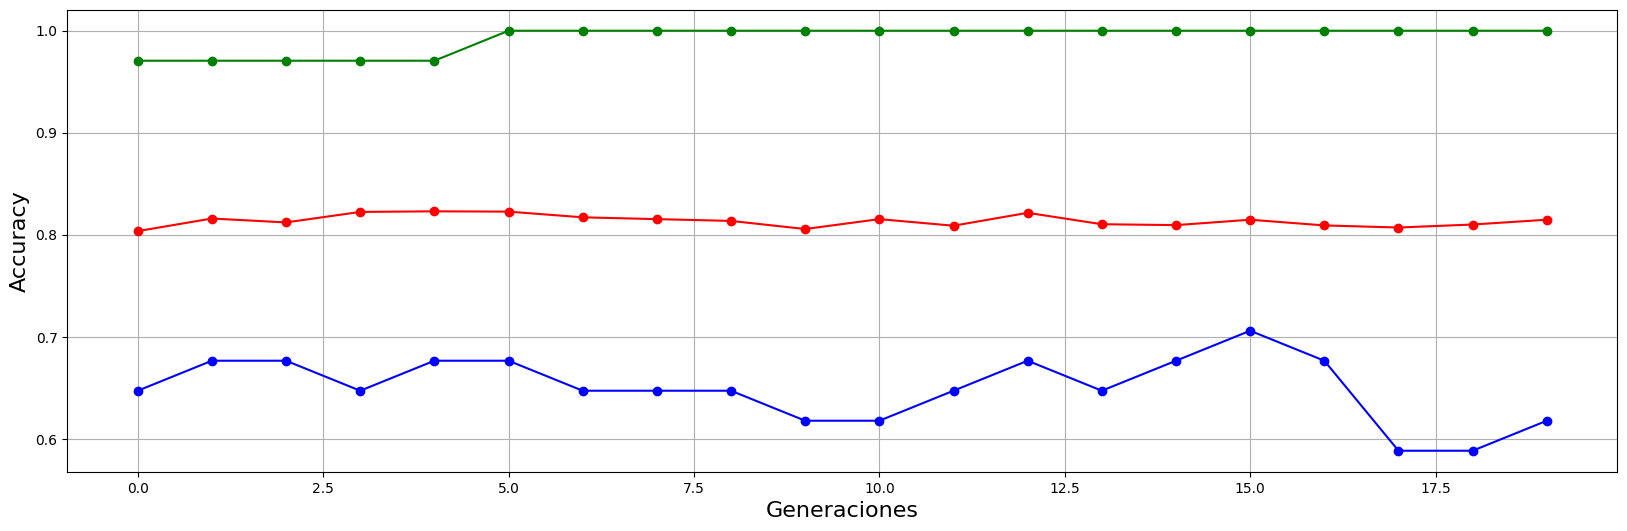

In [16]:
f_avg = logbook.chapters['acc'].select('avg')  # Extraemos fitness promedio a lo largo de las épocas
f_max = logbook.chapters['acc'].select('max')  # Extraemos fitness máximo a lo largo de las épocas
f_min = logbook.chapters['acc'].select('min')  # Extraemos fitness mínimo (elite) a lo largo de las épocas

N = 30 if GMAX > 200 else GMAX 
fig, ax = plt.subplots(1, 1, figsize=(20,6)) 
ax.plot(range(N), f_avg[:N], '-or')
ax.plot(range(N), f_max[:N], '-og')
ax.plot(range(N), f_min[:N], '-ob')
ax.set_xlabel('Generaciones', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.grid(True)

## Graficamos la evolución del número de genes

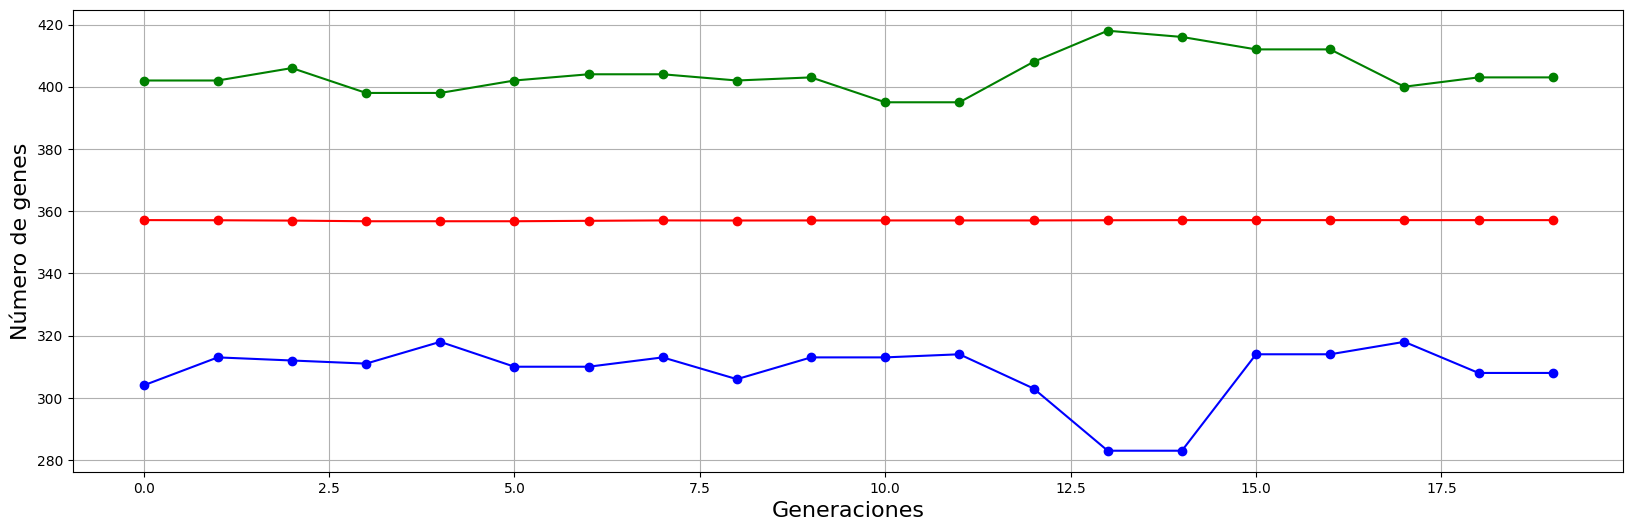

In [17]:
ngenes_avg = logbook.chapters['ngenes'].select('avg')  # Extraemos fitness promedio a lo largo de las épocas
ngenes_max = logbook.chapters['ngenes'].select('max')  # Extraemos fitness máximo a lo largo de las épocas
ngenes_min = logbook.chapters['ngenes'].select('min')  # Extraemos fitness mínimo (elite) a lo largo de las épocas

N = 100 if GMAX > 2000 else GMAX 
fig, ax = plt.subplots(1, 1, figsize=(20,6)) 
ax.plot(range(N), ngenes_avg[:N], '-or')
ax.plot(range(N), ngenes_max[:N], '-og')
ax.plot(range(N), ngenes_min[:N], '-ob')
ax.set_xlabel('Generaciones', fontsize=16)
ax.set_ylabel('Número de genes', fontsize=16)
ax.grid(True)